 # Final Project
 ## Loan Default Prediction
 
 ## Name: Fangzhou Song


### Problem statement

Problem: How to predict a loan application might be default in the end? 



### Problem statement

**Goal**: Given relevant information of the application, predict whether this loan will be default or not 

**Input**: All relevant factors  

**Output**: Probability of the loan being default 

**Type**: Supervised learning



### Problem statement
**Specific model**:
1. Logistic Regression  
2. Neural Network

**Measurable comparison**
1. Accuracy
2. Area Under Curve(AUC)



### Data description

The dataset is downloaded from https://www.lendingclub.com/info/download-data.action (2012 - 2017)


LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California, which is the world's largest peer-to-peer lending platform


The dataset contain complete loan data for all loans issued through the time period stated, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information.




### Data description
#### Partial dataset selection

For my project, I select 2016Q2 as my dataset as following reason:
1. The whole loan data from 2012-2017 is so big that the speed is quite slow when we applied machine learning algorthm


2. Even for 2016Q2, the number of rows is aleady very large


3. More data does not always mean better performance of the model
    * Getting more data will help much only if a learning algorithm is suffering high variance rather than high bias
    * Relatively small dataset is a good choice for initial exploration


In [14]:
import random
import pandas as pd
import numpy as np
import scipy.optimize as op
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(233)

### Data description

Read data

In [15]:
data=pd.read_csv(r"C:\Users\ArkSong\Desktop\GWU\Machine Learning 1\Final Project\Code\2016Q1.csv")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133887 entries, 0 to 133886
Columns: 145 entries, id to settlement_term
dtypes: float64(68), int64(40), object(37)
memory usage: 148.1+ MB


E:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Data processing

* Not use all columns. 
* Select some of them by hand which I think may have effect on default


In [16]:
data_total=data[['loan_amnt','int_rate','installment','annual_inc','inq_fi','pub_rec_bankruptcies','tax_liens',
            'dti','delinq_2yrs','open_acc','pub_rec','revol_bal','revol_util','total_acc','bc_util',
            'term','grade','home_ownership','verification_status','initial_list_status', #categorical
            'loan_status']]
data_total=data_total.dropna()
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132635 entries, 0 to 133842
Data columns (total 21 columns):
loan_amnt               132635 non-null int64
int_rate                132635 non-null object
installment             132635 non-null float64
annual_inc              132635 non-null float64
inq_fi                  132635 non-null float64
pub_rec_bankruptcies    132635 non-null int64
tax_liens               132635 non-null int64
dti                     132635 non-null float64
delinq_2yrs             132635 non-null int64
open_acc                132635 non-null int64
pub_rec                 132635 non-null int64
revol_bal               132635 non-null int64
revol_util              132635 non-null object
total_acc               132635 non-null int64
bc_util                 132635 non-null float64
term                    132635 non-null object
grade                   132635 non-null object
home_ownership          132635 non-null object
verification_status     132635 non-null object

Varible names | Type | Explaination 
 - | - | -
loan_amnt | int | The listed amount of the loan applied for by the borrower
int_rate | object | Interest Rate on the loan
installment | float | The monthly payment owed by the borrower if the loan originates
annual_inc | float | The self-reported annual income provided by the borrower during registration
inq_fi | float | Number of personal finance inquiries
pub_rec_bankruptcies | int | Number of public record bankruptcies
tax_liens | int | Number of tax liens
dti | float | A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations
delinq_2yrs | int | The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
open_acc | int | The number of open credit lines in the borrower's credit file
pub_rec | int | Number of derogatory public records
revol_bal | int | Total credit revolving balance
revol_util | int | Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit
total_acc | int | The total number of credit lines currently in the borrower's credit file
bc_util | float | Ratio of total current balance to high credit/credit limit for all bankcard accounts.
term | categorical | The number of payments on the loan. Values are in months and can be either 36 or 60
grade | categorical | LC assigned loan grade
home_ownership | categorical | The home ownership status provided by the borrower during registration
verification_status | categorical |Indicates if the co-borrowers' joint income was verified by LC
loan_status | categorical | Current status of the loan


### Data processing
#### Handle with response variable (Y)


In [17]:
data_total['loan_status'].value_counts()

Fully Paid            57243
Current               52247
Charged Off           20037
Late (31-120 days)     1671
In Grace Period         854
Late (16-30 days)       515
Default                  68
Name: loan_status, dtype: int64

> The term "charge off" means that the original creditor has given up on being repaid according to the original terms of the loan. It considers the remaining balance to be bad debt, but that doesn't mean you no longer owe the amount that has not been repaid.

* Combine Default with Charged Off
* Delete data with other **Loan Status**

In [18]:
data_total=data_total[(data_total.loan_status=='Fully Paid')|
        (data_total.loan_status=='Charged Off')|
        (data_total.loan_status=='Default')]

data_total['loan_status'][data_total.loan_status=='Default']='Charged Off'

data_total['loan_status'].value_counts()

Fully Paid     57243
Charged Off    20105
Name: loan_status, dtype: int64

* After combination

In [19]:
pd.set_option('display.max_columns', None)


data_total.head(8)

,loan_amnt,int_rate,installment,annual_inc,inq_fi,pub_rec_bankruptcies,tax_liens,dti,delinq_2yrs,open_acc,pub_rec,revol_bal,revol_util,total_acc,bc_util,term,grade,home_ownership,verification_status,initial_list_status,loan_status
0,8400,9.75%,270.06,66000.0,1.0,0,0,13.84,0,7,0,11059,78.40%,22,90.6,36 months,B,MORTGAGE,Not Verified,w,Fully Paid
4,20000,11.99%,664.20,49000.0,0.0,0,0,15.58,1,8,0,19014,89.70%,28,96.3,36 months,C,MORTGAGE,Source Verified,w,Fully Paid
5,13625,15.31%,326.36,50000.0,2.0,0,0,30.41,0,21,0,9650,12.40%,72,14.0,60 months,C,MORTGAGE,Not Verified,w,Fully Paid
7,15000,19.53%,393.50,63890.0,13.0,0,0,20.36,0,7,0,4307,40.60%,8,40.6,60 months,D,RENT,Not Verified,w,Charged Off
11,5000,9.75%,160.75,40000.0,1.0,1,0,10.38,0,25,1,6136,33%,45,62.4,36 months,B,OWN,Source Verified,w,Fully Paid
12,5000,16.29%,176.51,105000.0,1.0,0,0,9.07,0,13,0,3791,67.70%,15,67.7,36 months,D,MORTGAGE,Not Verified,w,Charged Off
13,4000,11.99%,132.84,36000.0,0.0,0,0,16.40,0,5,0,12333,98.70%,7,98.7,36 months,C,RENT,Verified,w,Charged Off
14,24000,9.75%,771.60,50000.0,0.0,0,0,24.46,0,8,0,15702,54.10%,14,49.4,36 months,B,MORTGAGE,Verified,w,Charged Off


* There are still some categorical variables in dataset

### Data Processing
#### Create Dummy Variables



In [20]:
verification_status_d=pd.get_dummies(data_total.verification_status)
verification_status_d.head(10)

,Not Verified,Source Verified,Verified
0,1,0,0
4,0,1,0
5,1,0,0
7,1,0,0
11,0,1,0
12,1,0,0
13,0,0,1
14,0,0,1
18,1,0,0
19,1,0,0


### Data Processing
####  Dummy Variables multicollinearity
* Drop one of the category


In [21]:
verification_status_d.drop(labels='Not Verified',axis=1,inplace=True)
verification_status_d.head(8)

,Source Verified,Verified
0,0,0
4,1,0
5,0,0
7,0,0
11,1,0
12,0,0
13,0,1
14,0,1


In [22]:
# term
term_d=pd.get_dummies(data_total.term)
term_d.drop(labels=' 36 months',axis=1,inplace=True) #60 months=1 36 months=0

#grade
grade_d=pd.get_dummies(data_total.grade)
grade_d.drop(labels='G',axis=1,inplace=True)  #drop  grade G

#home_ownership
home_ownership_d=pd.get_dummies(data_total.home_ownership)
home_ownership_d.drop(labels='RENT',axis=1,inplace=True) #drop RENT

#verification_status
verification_status_d=pd.get_dummies(data_total.verification_status)
verification_status_d.drop(labels='Not Verified',axis=1,inplace=True) #drop Not Verified

#initial_list_status
initial_list_status_d=pd.get_dummies(data_total.initial_list_status)
initial_list_status_d.drop(labels='w',axis=1,inplace=True)

#loan_status
loan_status_d=pd.get_dummies(data_total.loan_status)
loan_status_d.drop(labels='Fully Paid',axis=1,inplace=True)
loan_status_d.rename(columns={'Charged Off':'Charged_Off'},inplace=True)

data_total['int_rate']=data_total['int_rate'].str.strip('%').astype(float)/100
data_total['revol_util']=data_total['revol_util'].str.strip('%').astype(float)/100

### Data Processing

After creating dummy variables, concatenate them with original dataset

In [23]:
data_total=pd.concat([data_total,term_d,grade_d,home_ownership_d,
                 verification_status_d,initial_list_status_d,loan_status_d],axis=1)
    


data_total.drop(labels=['loan_status','term','grade','home_ownership',
                   'verification_status','initial_list_status'],axis=1,inplace=True)

### Feature relevance analysis 
#### Calculate Correalation

* Select all numerical variables
* Calculate Pearson correlation coefficient 

In [24]:
df_temp=data_total[['Charged_Off','loan_amnt','int_rate','installment','annual_inc','inq_fi','pub_rec_bankruptcies','tax_liens',
            'dti','delinq_2yrs','open_acc','pub_rec','revol_bal','revol_util','total_acc','bc_util']]


In [25]:
corr=df_temp.corr()

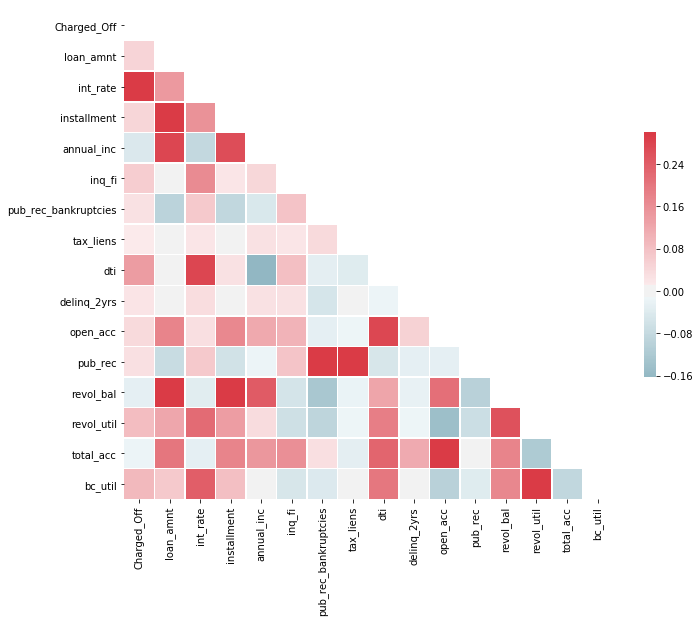

In [26]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Data normalization

* Use Standard Scaler
* Increase the speed of convergence in learning algorithm in later use
* Significant improvement in Neural network training

In [27]:
def feature_norm(X):
    X=(X-X.mean(axis=0))/X.std(axis=0)
    return X
    
data_total['loan_amnt']=feature_norm(data_total.loan_amnt)
data_total['installment']=feature_norm(data_total.installment)
data_total['annual_inc']=feature_norm(data_total.annual_inc)
data_total['revol_bal']=feature_norm(data_total.revol_bal)

### Training / Cross-validation / Test dataset generation

* Proportion:
    * Training set: 60%
    * Cross-validation set: 20%
    * Test set: 20%

In [28]:
def shuffle(df):
    df_0=df[df.Charged_Off==0] # Divide
    df_1=df[df.Charged_Off==1]
    df_0=df_0.sample(frac=1,random_state=233).reset_index(drop=True)  # shuffle
    df_1=df_1.sample(frac=1,random_state=233).reset_index(drop=True)
    m0=len(df_0)
    m1=len(df_1)
    
    df_0_train=df_0[0:int(m0*0.6)]     # 60% for training set
    df_1_train=df_1[0:int(m1*0.6)]
    
    df_0_cv=df_0[int(m0*0.6):int(m0*0.8)] # 20% for cross-validation set
    df_1_cv=df_1[int(m1*0.6):int(m1*0.8)]
    
    df_0_test=df_0[int(m0*0.8):]   # 20% for test set
    df_1_test=df_1[int(m1*0.8):]
    
    frames_train=[df_0_train,df_1_train] # Combine
    frames_cv=[df_0_cv,df_1_cv]
    frames_test=[df_0_test,df_1_test]
    data_train=pd.concat(frames_train) 
    data_cv=pd.concat(frames_cv)
    data_test=pd.concat(frames_test)
    
    data_train=data_train.sample(frac=1,random_state=23).reset_index(drop=True)  # after concation, reshuffle
    data_cv=data_cv.sample(frac=1,random_state=23).reset_index(drop=True)        # Make sure each set have
    data_test=data_test.sample(frac=1,random_state=23).reset_index(drop=True)    # same Full_paid / Default ratio
    
    return data_train,data_cv,data_test    
data_train,data_cv,data_test=shuffle(data_total)

### Model building
**Pros and cons**

1. Logistic Regression
    * The most common
    * Fast and easy to implement
    * Better fit for linear separation   

2. Neural Network
    * More complex 
    * Take more time to train
    * Better fit for non-linear separation
    

### Model building
**Output evaluation**

1. Accuracy
    * All model use same cut-off (such as 0.5) to compare
    * Event probability / rate: Intuitive
    * Fixed cut-off:  May not be appropriate for every model

2. Area Under Curve(AUC)
    * More universality: Each model has only 1 AUC
    * Hard to interpret directly

### Logistic regression

1. Use statistical package
    * Quick implementation
    * Nice visualization
    
2. Build model by hand
    * Draw learning curve plot
    * Introduce regularization parameter
    * Later use for neural network model

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
X_train=data_train[['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'inq_fi',
       'pub_rec_bankruptcies', 'tax_liens', 'dti', 'delinq_2yrs', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'bc_util',
       ' 60 months', 'A', 'B', 'C', 'D', 'E', 'F', 'MORTGAGE', 'OWN',
       'Source Verified', 'Verified', 'f']]
Y_train=data_train[ 'Charged_Off']

X_test=data_test[['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'inq_fi',
       'pub_rec_bankruptcies', 'tax_liens', 'dti', 'delinq_2yrs', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'bc_util',
       ' 60 months', 'A', 'B', 'C', 'D', 'E', 'F', 'MORTGAGE', 'OWN',
       'Source Verified', 'Verified', 'f']]
Y_test=data_test[ 'Charged_Off']

#### 1. Use statistical package

In [31]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_model=sm.Logit(Y_train,X_train)
result=logit_model.fit()

Optimization terminated successfully.
         Current function value: inf
         Iterations 6


In [32]:
print(result.summary2())

                           Results: Logit
Model:                  Logit              Pseudo R-squared:   inf   
Dependent Variable:     Charged_Off        AIC:                inf   
Date:                   2018-12-11 16:24   BIC:                inf   
No. Observations:       46408              Log-Likelihood:     -inf  
Df Model:               26                 LL-Null:            0.0000
Df Residuals:           46381              LLR p-value:        1.0000
Converged:              1.0000             Scale:              1.0000
No. Iterations:         6.0000                                       
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
loan_amnt            -0.2598   0.0864  -3.0065 0.0026 -0.4291 -0.0904
int_rate             -0.7801   0.4715  -1.6547 0.0980 -1.7042  0.1439
installment           0.3078   0.0806   3.8170 0

In [33]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

print('Accuracy of logistic regression classifier on test set: {:.8f}'.format(logreg.score(X_test, Y_test)))

Accuracy of logistic regression classifier on test set: 0.74861021


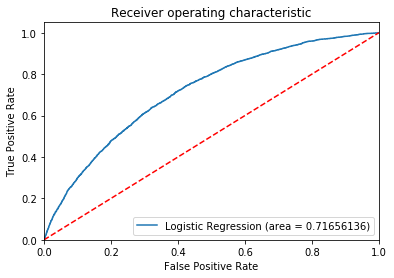

In [34]:
logit_roc_auc = roc_auc_score(Y_test, logreg.predict_proba(X_test)[...,1])

fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.8f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### Build model by hand

1. Sigmoid function
2. Cost function
3. Gradient function

In [35]:
data_train=data_train.values
data_cv=data_cv.values
data_test=data_test.values

X_train=np.array(data_train[...,0:(data_train.shape[1]-1)])
Y_train=np.array(data_train[...,data_train.shape[1]-1])

X_train=X_train.reshape(len(X_train),(data_train.shape[1]-1))
Y_train=Y_train.reshape(len(Y_train),1)

X_train = X_train.astype(float)
Y_train = Y_train.astype(float)


X_cv=np.array(data_cv[...,0:(data_cv.shape[1]-1)])
Y_cv=np.array(data_cv[...,data_cv.shape[1]-1])

X_cv=X_cv.reshape(len(X_cv),(data_cv.shape[1]-1))
Y_cv=Y_cv.reshape(len(Y_cv),1)

X_cv = X_cv.astype(float)
Y_cv = Y_cv.astype(float)


X_test=np.array(data_test[...,0:(data_test.shape[1]-1)])
Y_test=np.array(data_test[...,data_test.shape[1]-1])

X_test=X_test.reshape(len(X_test),(data_test.shape[1]-1))
Y_test=Y_test.reshape(len(Y_test),1)

X_test = X_test.astype(float)
Y_test = Y_test.astype(float)

In [36]:
def sigmoid(z):
    
    g=1.0/(1.0+np.exp(-z))
    return g

def costfunction(theta,X,Y,lam):
    m,n=X.shape
    theta=theta.reshape((n,1))
    J=sum(-Y*np.log(sigmoid(np.dot(X,theta)))-
          (1-Y)*np.log(1-sigmoid(np.dot(X,theta))))/m
    J=J+lam*sum(theta[1:n,0]**2)/(2*m)
    return J

def gradient(theta,X,Y,lam):
    m,n=X.shape
    theta=theta.reshape((n,1))
    grad=np.dot(X.T,(sigmoid(np.dot(X,theta))-Y))/m
    temp=np.append(0,lam*theta[1:,...]/m)
    temp=temp.reshape((n,1))
    grad=grad+temp
    return grad.flatten()

In [37]:
def init_data(X):
    m,n=X.shape
    X=np.column_stack((np.ones((m,1)),X))
    return X

def predict(theta,X):
    X=init_data(X)
    pred=sigmoid(np.dot(X,theta))        
    return pred

def cut_off(pred):
    m=len(pred)
    res=np.zeros(m)
    for i in range(0,m):
        if pred[i]>=0.5:
            res[i]=1
        else:
            res[i]=0
    res=res.reshape((m,1))
    return res
    
def train(X,Y,lam):
    m,n=X.shape
    init_theta=np.zeros(n+1)
    X=init_data(X)
    result=op.minimize(fun=costfunction,x0=init_theta,args=(X,Y,lam),
                       method='TNC',jac=gradient,options={'maxiter':1000})
    theta=result.x
    return theta

#### Train the model and test

In [38]:
theta=train(X_train,Y_train,0)

Y_test_pred=predict(theta,X_test)


res=cut_off(Y_test_pred)

print('Accuracy under 0.5 is',np.mean(res==Y_test)*100)



print('AUC is',roc_auc_score(Y_test,Y_test_pred))

Accuracy under 0.5 is 74.86102133160956
AUC is 0.716633016865839


* Compared to result using package: Accuracy 0.75, AUC 0.71656

#### Learning curve
* For training set size in 1:m, train the model to get theta
* Calculate the cost in traning set and cross-validation set
* Plot two cost with training size

In [39]:
def learning_curve(X,Y,X_cv,Y_cv,lam):
    m=1000
    error_train=np.zeros((m,1))
    error_cv=np.zeros((m,1))
    X_cv=init_data(X_cv)    
    for i in range(0,m):
        theta=train(X[0:(i+1),...],Y[0:(i+1),...],lam)
        X_temp=init_data(X[0:(i+1),...])
        Y_temp=Y[0:(i+1),...]
        Jt=costfunction(theta,X_temp,Y_temp,lam)        
        Jv=costfunction(theta,X_cv,Y_cv,lam)
        error_train[i,0]=Jt
        error_cv[i,0]=Jv    
    return error_train,error_cv

In [40]:
error_train,error_cv=learning_curve(X_train,Y_train,X_cv,Y_cv,0)

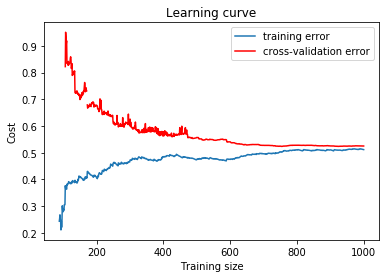

In [41]:
plt.figure()
plt.plot(range(88,1001),error_train[87:,...],label='training error')
plt.plot(range(88,1001),error_cv[87:,...],color='red',label='cross-validation error')
plt.xlabel('Training size')
plt.ylabel('Cost')
plt.title('Learning curve')
plt.legend(loc="upper right")
plt.show()

### Neural Network

* Model: 1 hidden layer
* Input layer size: 27
* Hidden layer size: 10
* Number of labels: 1

In [42]:
def sigmoid_grad(z):
    g_grad=sigmoid(z)*(1-sigmoid(z))
    return g_grad

def randinit_weights(L_in,L_out):
    epsilon_init=np.sqrt(6)/np.sqrt(L_in+L_out)
    W=np.random.rand(L_in+1,L_out)*2*epsilon_init-epsilon_init
    return W

In [43]:
def costfunction_nn(theta,input_layer_size,hidden_layer_size,num_labels,X,Y,lam):    
    theta1=theta[0:(hidden_layer_size*(input_layer_size+1))]
    theta2=theta[(hidden_layer_size*(input_layer_size+1)):]
    theta1=theta1.reshape(((input_layer_size+1),hidden_layer_size))
    theta2=theta2.reshape(((hidden_layer_size+1),num_labels))    
    m,n=X.shape
    X=np.column_stack((np.ones((m,1)),X))
    
    z_2=np.dot(X,theta1)
    a_2=sigmoid(z_2)
    a_2=np.column_stack((np.ones((m,1)),a_2))
    z_3=np.dot(a_2,theta2)
    a_3=sigmoid(z_3)
    J=sum(-Y*np.log(a_3)-(1-Y)*np.log(1-a_3))/m
    J=J+lam*(sum(sum(theta1[1:,...]**2))+
         sum(sum(theta2[1:,...]**2)))/(2*m)
    return J

In [44]:
def gradient_nn(theta,input_layer_size,hidden_layer_size,num_labels,X,Y,lam):
    
    theta1=theta[0:(hidden_layer_size*(input_layer_size+1))]
    theta2=theta[(hidden_layer_size*(input_layer_size+1)):]
    theta1=theta1.reshape(((input_layer_size+1),hidden_layer_size))
    theta2=theta2.reshape(((hidden_layer_size+1),num_labels))    
    m,n=X.shape
    X=np.column_stack((np.ones((m,1)),X))
    
    z_2=np.dot(X,theta1)
    a_2=sigmoid(z_2)
    a_2=np.column_stack((np.ones((m,1)),a_2))
    z_3=np.dot(a_2,theta2)
    a_3=sigmoid(z_3)
    
    delta_3=a_3-Y  #Backpropagation
    D_2=np.dot(a_2.T,delta_3)
    theta2_grad=D_2/m
    theta2a=theta2[1:,...]
    delta_2=np.dot(delta_3,theta2a.T)*sigmoid_grad(z_2)
    D_1=np.dot(X.T,delta_2)
    theta1_grad=D_1/m
    
    theta1_grad=(theta1_grad+np.row_stack((np.zeros((1,theta1.shape[1])),lam*theta1[1:,...]/m)))   
    theta2_grad=(theta2_grad+np.row_stack((np.zeros((1,theta2.shape[1])),lam*theta2[1:,...]/m))) 
    grad=np.append(theta1_grad.flatten(),theta2_grad.flatten())
    return grad

In [45]:
def predict_nn(theta,X,input_layer_size,hidden_layer_size,cut_off,num_labels):
    
    theta1=theta[0:(hidden_layer_size*(input_layer_size+1))]
    theta2=theta[(hidden_layer_size*(input_layer_size+1)):]
    theta1=theta1.reshape(((input_layer_size+1),hidden_layer_size))
    theta2=theta2.reshape(((hidden_layer_size+1),num_labels))
    
    m,n=X.shape
    X=np.column_stack((np.ones((m,1)),X))
    
    z_2=np.dot(X,theta1)
    a_2=sigmoid(z_2)
    a_2=np.column_stack((np.ones((m,1)),a_2))
    z_3=np.dot(a_2,theta2)
    a_3=sigmoid(z_3)
    
    pred=a_3        
    return pred

In [46]:
input_layer_size=27
hidden_layer_size=10
num_labels=1
lam=1

theta1=randinit_weights(input_layer_size,hidden_layer_size)
theta2=randinit_weights(hidden_layer_size,num_labels)

theta=np.append(theta1.flatten(),theta2.flatten())

J=costfunction_nn(theta,input_layer_size,hidden_layer_size,num_labels,X_train,Y_train,lam)

grad=gradient_nn(theta,input_layer_size,hidden_layer_size,num_labels,X_train,Y_train,lam)

result=op.minimize(fun=costfunction_nn,x0=theta,
                   args=(input_layer_size,hidden_layer_size,num_labels,
                         X_train,Y_train,lam),method='TNC',jac=gradient_nn,options={'maxiter':10000})


In [47]:
print(result)

theta_f=result.x

     fun: array([0.50999232])
     jac: array([ 1.05771583e-07,  9.76087744e-07, -1.98033792e-06, -5.92817267e-07,
       -8.25338099e-07, -3.48855152e-06,  2.30628504e-06,  1.90405849e-06,
        6.97620214e-07, -5.51740146e-06, -9.04115260e-08, -5.22746401e-07,
        1.83882028e-06,  1.28560751e-07,  1.31074292e-06,  2.26612147e-06,
       -1.74516331e-06, -5.77774234e-07,  2.38818625e-07,  4.37467650e-06,
        1.61579449e-08,  1.08465278e-07, -1.59254358e-07, -6.93502477e-08,
       -1.73284027e-07, -6.67414914e-07,  6.13609805e-08,  3.66381737e-08,
        1.40479787e-07, -7.15239189e-07, -5.53798932e-08, -5.44835964e-07,
        1.30651634e-06,  2.36212892e-07,  4.90936546e-07,  1.66560340e-06,
       -6.24412342e-07, -1.07401386e-06,  4.81456405e-07,  1.93167199e-06,
       -3.50334446e-08, -3.84212083e-07,  1.07320485e-06,  2.52003614e-07,
        2.27347928e-06,  4.61832453e-06, -2.40310394e-06, -1.28936421e-06,
       -1.97229744e-07,  2.48005046e-06,  7.44246185e-08,  6

### For training set

In [48]:
pred=predict_nn(theta_f,X_train,input_layer_size,hidden_layer_size,cut_off,num_labels)

res=cut_off(pred)

print('Accuracy under 0.5 is',np.mean(res==Y_train)*100) 
print('AUC is',roc_auc_score(Y_train,pred))

Accuracy under 0.5 is 75.5408550249957
AUC is 0.7265149733685119


### For test set

In [49]:
pred=predict_nn(theta_f,X_test,input_layer_size,hidden_layer_size,cut_off,num_labels)

res=cut_off(pred)

print('Accuracy under 0.5 is',np.mean(res==Y_test)*100) 
print('AUC is',roc_auc_score(Y_test,pred))

Accuracy under 0.5 is 74.72527472527473
AUC is 0.7178982105671141


###  Conclusion
#### Findings of models

1. Result of Logistic regression seems good with Accuracy 0.75 and AUC 0.716
2. Learning Curve is the shaple of high bias
    * Larger training set will not help much
    * Try one hidden layer neural network
3. Neural network just increase AUC from 0.716 to 0.719
    * Still need improvement

###  Conclusion
#### Findings of machine learning

1. Data processing is a really important procedure in application
    * Take more time than expected
    * Programing language for quick update instead of involving with excel

2. Logistic regression is a powerful model
    * Quick implement using some stat package


###  Conclusion
#### Future work

1. Try getting more features
2. Add some polynomial terms
3. Add more hidden layers in neural network


# Thanks for watching 